In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from kiwipiepy import Kiwi

from wordcloud import WordCloud
import networkx as nx

from sklearn.decomposition import TruncatedSVD, NMF
from factor_analyzer.rotator import Rotator
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from sklearn.model_selection import train_test_split

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [2]:
lpay_b = pd.read_csv('../../3. 에포크_데이터 및 모델 세이브 파일/data/text/naver_blog_lpay.csv')
lpoint_b = pd.read_csv('../../3. 에포크_데이터 및 모델 세이브 파일/data/text/naver_blog_lpoint.csv')

In [3]:
lpay_b['keyword'] = 'lpay'
lpoint_b['keyword'] = 'lpoint'

In [4]:
corpora_df = pd.concat([lpay_b, lpoint_b])
corpora_df.drop_duplicates(inplace=True)
corpora_df.reset_index(drop=True, inplace=True)

In [5]:
corpora_df.title.fillna('', inplace=True)
corpora_df.context.fillna('', inplace=True)

### Preprocessing

In [6]:
corpora_df.date.loc[corpora_df.date.map(lambda x: x.endswith('전'))] = '2022. 7. 4. 00:00'
corpora_df['date'] = pd.to_datetime(corpora_df['date'])

In [7]:
corpora_df['year'] = corpora_df.date.dt.year
corpora_df['month'] = corpora_df.date.dt.month

corpora_df['year_month'] = corpora_df[['year', 'month']].apply(lambda x: str(x[0])+'_'+str(x[1]), axis=1)

In [8]:
corpora_df.year_month = corpora_df.year_month.astype('category')
corpora_df.year_month = corpora_df.year_month.cat.reorder_categories([f'{i}_{j}' for i in sorted(corpora_df.year.unique()) for j in range(1,13)
                                                  if ((f'{i}_0{j}' in corpora_df.year_month.unique()) | (f'{i}_{j}' in corpora_df.year_month.unique()))])

In [9]:
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'[^\w\s]',' ',x))
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'\s+', ' ', x).lower())
corpora_df.context = corpora_df.context.map(lambda x: re.sub(r'\n+', '\n', x))

In [11]:
stop_word = pd.read_csv("../../3. 에포크_데이터 및 모델 세이브 파일/data/text/korean_stopwords.txt")
stop_word = stop_word.T.reset_index(drop=False).T.reset_index(drop = True)
stop_word.columns = ["token"]

In [12]:
def extract_nvi(text):
    kiwi = Kiwi()
    result = kiwi.analyze(text)
    stop_words = list(stop_word['token'])
    for token, pos, _, _ in result[0][0]:
        if pos[0] in 'NVI':
            if token not in stop_words:
                if len(token) > 1:
                    yield token

In [ ]:
cv = CountVectorizer(tokenizer=extract_nvi, max_features=5000)
trans_tfidf = TfidfTransformer()
tdm_cv = cv.fit_transform(corpora)
tdm_tfidf = trans_tfidf.fit_transform(tdm_cv)

In [36]:
word_count = pd.DataFrame({
    '단어':cv.get_feature_names(),
    '빈도':tdm_cv.sum(axis=0).flat,
    '빈도가중치':tdm_tfidf.sum(axis=0).flat
})
word_count = word_count.sort_values('빈도', ascending=False).reset_index(drop=True)
word_count = word_count[word_count.빈도 >= 10].reset_index(drop=True)

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
lpoint_df = word_count[['단어', '빈도']].copy()
lpoint_df['출처'] = 'lpoint'
lpoint_df.to_csv('./download/lpoint_df.csv', index=False)

### WordCloud

In [13]:
with open('../../3. 에포크_데이터 및 모델 세이브 파일/model/text data analysis/cv_lpoint_blog.pkl', 'rb') as f:
    cv = pickle.load(f)
tdm_cv = np.load('../../3. 에포크_데이터 및 모델 세이브 파일/model/text data analysis/tdm_cv_lpoint_blog.npy', allow_pickle=True).tolist()
tdm_tfidf = np.load('../../3. 에포크_데이터 및 모델 세이브 파일/model/text data analysis/tdm_tfidf_lpoint_blog.npy', allow_pickle=True).tolist()
word_count = pd.read_csv('../../3. 에포크_데이터 및 모델 세이브 파일/model/text data analysis/word_count_lpoint_blog.csv')

In [30]:
im = Image.open('LPoint로고.png')
mask = Image.new("RGB", im.size, (255,255,255))
mask.paste(im,im)
mask_arr = np.array(mask)

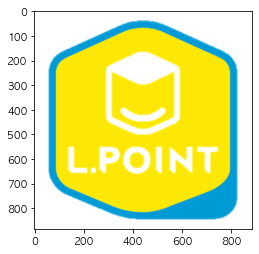

In [31]:
plt.imshow(mask_arr)
plt.show()

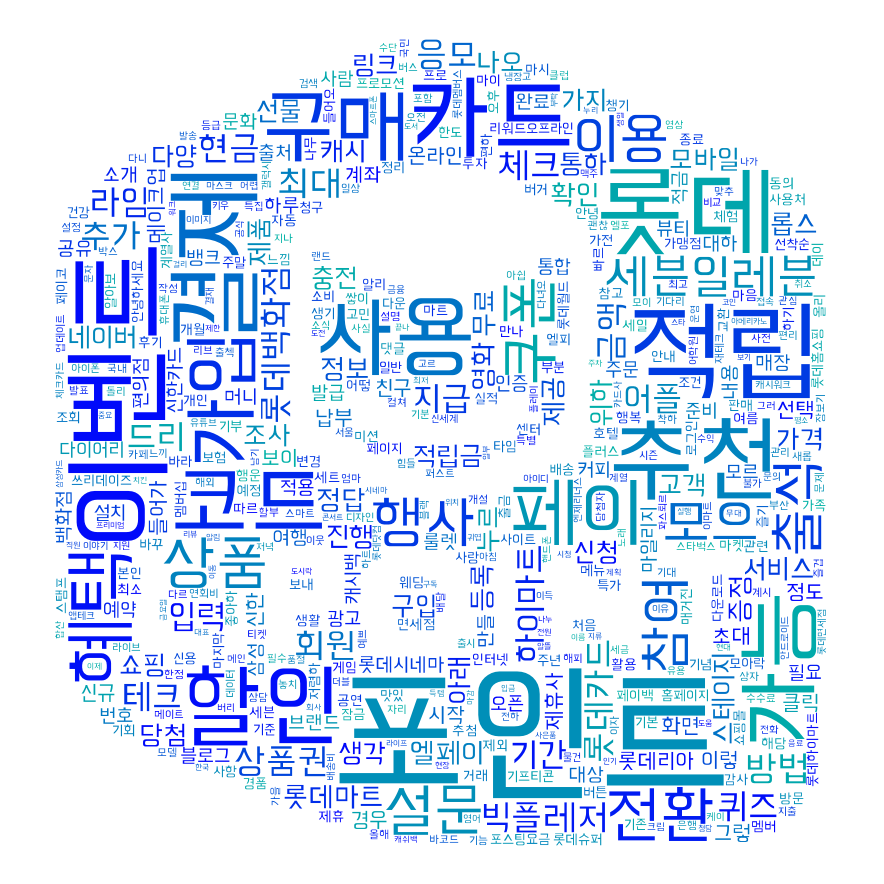

In [93]:
wc = WordCloud(max_words=500, background_color='white', mask=mask_arr, colormap=colors.LinearSegmentedColormap.from_list('trunc("winter_r,0.3,1")', plt.get_cmap('winter_r')(np.linspace(0.3,1))),
               font_path='/System/Library/AssetsV2/com_apple_MobileAsset_Font7/f7b33b6b63ac62df4a15ffb507b52db565b1091c.asset/AssetData/BMHannaAir-Regular.otf')
count_dict = dict(zip(word_count['단어'], word_count['빈도가중치']))
cloud = wc.fit_words(count_dict)
cloud.to_image()

### Topic Analysis

In [81]:
svd = TruncatedSVD(n_components=100, random_state=99)
svd.fit(tdm_tfidf)

TruncatedSVD(n_components=100, random_state=99)

#### 병렬 분석을 위한 차원 크기 결정

In [82]:
nrow, ncol = tdm_tfidf.shape

In [83]:
def resample(a):
    return np.random.choice(a, size=nrow)
np.random.seed(0)
d = np.apply_along_axis(resample, 0, tdm_tfidf.A) # 주어진 축에 따라 함수 적용

In [84]:
svd2 = TruncatedSVD(n_components=100, random_state=99)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=99)

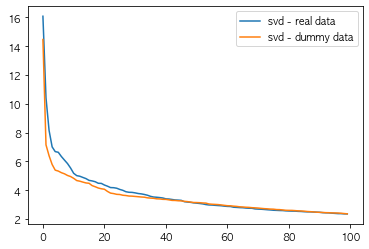

In [85]:
plt.plot(svd.singular_values_, label='svd - real data')
plt.plot(svd2.singular_values_, label='svd - dummy data')
plt.legend()
plt.show()

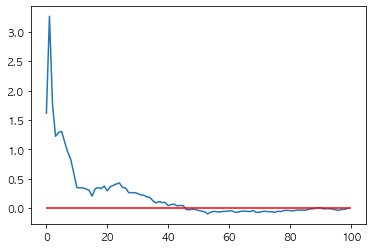

In [92]:
plt.plot(svd.singular_values_ - svd2.singular_values_ )
plt.hlines(0,0,100, colors='red')
plt.show()

In [86]:
np.argwhere(svd.singular_values_ - svd2.singular_values_ <= 0)[0] # dummy data보다 성능이 낮은 구간: 이 차원 보다 더 낮게 설정

array([46])

#### LSA

In [94]:
svd = TruncatedSVD(n_components=16, random_state=0)
svd.fit(tdm_tfidf)

TruncatedSVD(n_components=16, random_state=0)

In [95]:
doc_topics_lsa = svd.transform(tdm_tfidf)

In [96]:
doc_topics = corpora_df[['type','year','month','year_month']]
doc_topics['topics_lsa'] = doc_topics_lsa.argmax(axis=1)

/var/folders/ty/d0l26xd500q6hk3ryfccwjy00000gn/T/ipykernel_1229/2791503426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doc_topics['topics_lsa'] = doc_topics_lsa.argmax(axis=1)


Rotate

In [102]:
rotator = Rotator()
rot = rotator.fit_transform(svd.components_.T)
loading = rot.T

- 주제 0
  - 포인트, 적립, 쓰리데이즈, 사용, 전환, 쿠폰, 충전, 제휴사, 다이어리, 적금
- 주제 1
  - 코드, 추천, 캐시, 입력, 초대, 가입
- 주제 2
  - 적립, 결제, 사용, 쓰리데이즈, 코드, 라임
- 주제 3
  - 전환, 상품권, 상품, 롯데, 롯데백화점, 문화, 컬쳐, 지류, 교환, 랜드, 사용, 온라인, 백화점
- 주제 4
  - 빅플레저, 스테이지, 공연, 특집, 응모, 콘서트, 휘성, 뷰티, 무대, 코엑스, 노래, 자우림, 뮤지컬, 가수이름들~
- 주제 5
  - 전환, 포인트, 적금, 다이어리, 할인
- 주제 6
  - 모아락, 초대, 잠금, 롯데, 포인트, 화면, 설문, 링크, 조사, 결제, 설치
- 주제 7
  - 카드, 할인, 롯데카드, 발급, 혜택, 실적, 이용, 제공, 신용, 할부, 적용, 사용, 전월, 요금, 캐시백, 체크카드, 카드사
- 주제8
  - 설문, 라임, 조사, 추천, 가입, 나무, 참여
- 주제9
  - 세븐일레븐, 행사, 할인, 롯데리아, 편의점, 롯데마트, 쿠폰, 상품, 구매, 도시락, 증정, 상품(식품)들~
- 주제10
  - 출석, 체크, 모으, 모아락, 테크, 어플, 포인트, 룰렛, 출첵
- 주제11
  - 세븐일레븐, 롯데, 다이어리, 이벤트, 가입, 메이크업, 포인트, 코드, 롯데카드, 롭스, ~
- 주제12
  - 출석, 체크, 적립, 가입, 이벤트, 쓰리데이즈, 전환
- 주제13
  - 롯데, 적립, 웨딩, 가입, 롯데백화점, 마일리지, 적립금, 적금, 혜택, 
- 주제14
  - 메이크업, 롭스, 다이어리, 뷰티, 제품, 바르, 선물, 예쁘, 빅플레저뷰티, 눈썹, 화장
- 주제15
  - 적금, 뱅크, 가입, 계좌, 현금, 개설, 금리, 페이, 서비스
  
  
- 쓰리데이즈?
  - 3일 동안 포인트를 충전 후 사용하면 50% 재적립 이벤트

In [108]:
corpora_df['topic_lsa_rot'] = doc_topics_rot.argmax(axis=1)

/Users/kwon-yujin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


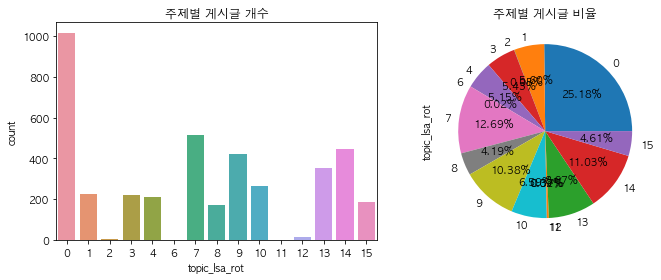

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(corpora_df.topic_lsa_rot, ax=axes[0])
corpora_df.groupby('topic_lsa_rot').topic_lsa_rot.count().plot.pie(autopct='%.2f%%', ax=axes[1])
axes[0].set_title('주제별 게시글 개수')
axes[1].set_title('주제별 게시글 비율')
plt.tight_layout()
plt.show()

- 주제 0이 압도적으로 많다. 그 뒤로는 7, 14, 9, 13이 가장 많음
  - 주제 0: 포인트 적립 관련 글(쓰리데이즈도 간간히 나옴)
  - 주제 7: 카드 관련 이벤트
  - 주제 14: 롭스 이벤트? 화장품 관련 단어 많음 - 빅플레져 뷰티
  - 주제 9: 출석 체크, 룰렛 이벤트
  - 주제 13: 롯데 백화점?
  - 주제 10: 출석 체크 관련
- 모두 이벤트 관련 게시글